In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_roi_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 1012)
(734160, 1)
validation
(101248, 1012)
(101248, 1)
test
(100432, 1012)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1012)]            0         


 dense (Dense)               (None, 1024)              1037312   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1726465 (6.59 MB)


Trainable params: 1726465 (6.59 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:34 - loss: 0.1593 - STD: 1.1928e-04 - MAE: 0.3867

 4/74 [>.............................] - ETA: 1s - loss: 0.0573 - STD: 4.9851e-04 - MAE: 0.1826  

 7/74 [=>............................] - ETA: 1s - loss: 0.0481 - STD: 3.4808e-04 - MAE: 0.1711

10/74 [===>..........................] - ETA: 1s - loss: 0.0449 - STD: 2.5905e-04 - MAE: 0.1674

13/74 [====>.........................] - ETA: 4s - loss: 0.0415 - STD: 2.1864e-04 - MAE: 0.1565

16/74 [=====>........................] - ETA: 3s - loss: 0.0362 - STD: 2.0090e-04 - MAE: 0.1398

19/74 [======>.......................] - ETA: 2s - loss: 0.0326 - STD: 1.9061e-04 - MAE: 0.1328

22/74 [=======>......................] - ETA: 2s - loss: 0.0305 - STD: 1.8155e-04 - MAE: 0.1309

25/74 [=========>....................] - ETA: 2s - loss: 0.0285 - STD: 1.7301e-04 - MAE: 0.1268

28/74 [==========>...................] - ETA: 1s - loss: 0.0267 - STD: 1.6500e-04 - MAE: 0.1204

31/74 [===========>..................] - ETA: 1s - loss: 0.0254 - STD: 1.5814e-04 - MAE: 0.1146

34/74 [============>.................] - ETA: 1s - loss: 0.0244 - STD: 1.5291e-04 - MAE: 0.1099

37/74 [==============>...............] - ETA: 1s - loss: 0.0234 - STD: 1.4956e-04 - MAE: 0.1060

40/74 [===============>..............] - ETA: 1s - loss: 0.0225 - STD: 1.4789e-04 - MAE: 0.1034

42/74 [================>.............] - ETA: 1s - loss: 0.0221 - STD: 1.4757e-04 - MAE: 0.1024

45/74 [=================>............] - ETA: 1s - loss: 0.0214 - STD: 1.4790e-04 - MAE: 0.1011

48/74 [==================>...........] - ETA: 0s - loss: 0.0208 - STD: 1.4866e-04 - MAE: 0.0994

50/74 [===================>..........] - ETA: 0s - loss: 0.0205 - STD: 1.4944e-04 - MAE: 0.0981

53/74 [====================>.........] - ETA: 0s - loss: 0.0200 - STD: 1.5111e-04 - MAE: 0.0962

56/74 [=====================>........] - ETA: 0s - loss: 0.0196 - STD: 1.5362e-04 - MAE: 0.0944

58/74 [======================>.......] - ETA: 0s - loss: 0.0193 - STD: 1.5586e-04 - MAE: 0.0934

60/74 [=======================>......] - ETA: 0s - loss: 0.0191 - STD: 1.5865e-04 - MAE: 0.0926

63/74 [========================>.....] - ETA: 0s - loss: 0.0187 - STD: 1.6396e-04 - MAE: 0.0917

65/74 [=========================>....] - ETA: 0s - loss: 0.0185 - STD: 1.6806e-04 - MAE: 0.0912

67/74 [==========================>...] - ETA: 0s - loss: 0.0183 - STD: 1.7253e-04 - MAE: 0.0906

69/74 [==========================>...] - ETA: 0s - loss: 0.0181 - STD: 1.7755e-04 - MAE: 0.0900

72/74 [============================>.] - ETA: 0s - loss: 0.0179 - STD: 1.8583e-04 - MAE: 0.0891

74/74 [==============================] - 4s 41ms/step - loss: 0.0177 - STD: 1.9205e-04 - MAE: 0.0885 - val_loss: 0.0145 - val_STD: 3.1273e-04 - val_MAE: 0.0707


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0122 - STD: 4.5027e-04 - MAE: 0.0666

 4/74 [>.............................] - ETA: 1s - loss: 0.0123 - STD: 4.8696e-04 - MAE: 0.0681

 7/74 [=>............................] - ETA: 1s - loss: 0.0122 - STD: 5.3016e-04 - MAE: 0.0692

10/74 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 5.7647e-04 - MAE: 0.0698

13/74 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 6.2705e-04 - MAE: 0.0699

16/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 6.8308e-04 - MAE: 0.0696

19/74 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 7.4666e-04 - MAE: 0.0691

22/74 [=======>......................] - ETA: 1s - loss: 0.0119 - STD: 8.2273e-04 - MAE: 0.0689

25/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 9.1467e-04 - MAE: 0.0690

27/74 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 9.8422e-04 - MAE: 0.0690

30/74 [===========>..................] - ETA: 1s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0690    

32/74 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0689

35/74 [=============>................] - ETA: 0s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0687

38/74 [==============>...............] - ETA: 0s - loss: 0.0118 - STD: 0.0015 - MAE: 0.0685

41/74 [===============>..............] - ETA: 0s - loss: 0.0117 - STD: 0.0018 - MAE: 0.0683

44/74 [================>.............] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0682

46/74 [=================>............] - ETA: 0s - loss: 0.0116 - STD: 0.0023 - MAE: 0.0681

48/74 [==================>...........] - ETA: 0s - loss: 0.0116 - STD: 0.0025 - MAE: 0.0680

51/74 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 0.0029 - MAE: 0.0677

53/74 [====================>.........] - ETA: 0s - loss: 0.0115 - STD: 0.0033 - MAE: 0.0675

55/74 [=====================>........] - ETA: 0s - loss: 0.0114 - STD: 0.0037 - MAE: 0.0673

57/74 [======================>.......] - ETA: 0s - loss: 0.0114 - STD: 0.0041 - MAE: 0.0671

59/74 [======================>.......] - ETA: 0s - loss: 0.0113 - STD: 0.0046 - MAE: 0.0668

62/74 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 0.0055 - MAE: 0.0664

65/74 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 0.0066 - MAE: 0.0659

68/74 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 0.0078 - MAE: 0.0653

71/74 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.0092 - MAE: 0.0647

74/74 [==============================] - ETA: 0s - loss: 0.0105 - STD: 0.0108 - MAE: 0.0639

74/74 [==============================] - 2s 28ms/step - loss: 0.0105 - STD: 0.0108 - MAE: 0.0639 - val_loss: 0.0063 - val_STD: 0.0381 - val_MAE: 0.0464


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0539 - MAE: 0.0445

 4/74 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0581 - MAE: 0.0436

 6/74 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0609 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0634 - MAE: 0.0421

11/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0411

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0402

16/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0398

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0392

22/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0387

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0383

27/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0380

30/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0377

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0374

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0372

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0820 - MAE: 0.0370

41/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0827 - MAE: 0.0368

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0831 - MAE: 0.0366

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0836 - MAE: 0.0365

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0843 - MAE: 0.0363

51/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0849 - MAE: 0.0362

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0853 - MAE: 0.0361

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0858 - MAE: 0.0359

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0864 - MAE: 0.0358

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0868 - MAE: 0.0357

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0872 - MAE: 0.0355

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0876 - MAE: 0.0354

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0880 - MAE: 0.0353

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0883 - MAE: 0.0352

74/74 [==============================] - 2s 28ms/step - loss: 0.0030 - STD: 0.0883 - MAE: 0.0352 - val_loss: 0.0026 - val_STD: 0.0727 - val_MAE: 0.0328


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0328

 3/74 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0323

 5/74 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0323

 7/74 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0323

10/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0323

12/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0324

15/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0323

18/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0957 - MAE: 0.0323

21/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0323

24/74 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0322

27/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0322

30/74 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0321

33/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0320

36/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0319

39/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0319

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0318

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0318

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0317

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0316

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0316

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0315

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0314

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0314

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0313

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0312

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0312

74/74 [==============================] - 2s 26ms/step - loss: 0.0022 - STD: 0.0972 - MAE: 0.0312 - val_loss: 0.0024 - val_STD: 0.0772 - val_MAE: 0.0314


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0300

 3/74 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0302

 6/74 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0302

 9/74 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0300

11/74 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0299

14/74 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0979 - MAE: 0.0298

17/74 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0978 - MAE: 0.0297

20/74 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0979 - MAE: 0.0297

23/74 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0979 - MAE: 0.0296

26/74 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0980 - MAE: 0.0297

29/74 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0981 - MAE: 0.0297

32/74 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0980 - MAE: 0.0298

35/74 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.0980 - MAE: 0.0299

38/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0299

41/74 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0299

44/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0299

46/74 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0298

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0297

52/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0297

55/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0296

58/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0295

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0295

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0294

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0294

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0293

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293

74/74 [==============================] - 2s 28ms/step - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293 - val_loss: 0.0022 - val_STD: 0.0764 - val_MAE: 0.0296


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0988 - MAE: 0.0280

 3/74 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0283

 5/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0284

11/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0284

14/74 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0285

17/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

20/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0284

23/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0284

26/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0284

29/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0284

32/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0284

35/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

38/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0283

41/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

43/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0282

47/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0282

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0284

53/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0285

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0286

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0293

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

74/74 [==============================] - 2s 28ms/step - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293 - val_loss: 0.0022 - val_STD: 0.0777 - val_MAE: 0.0311


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0292

 3/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.0982 - MAE: 0.0289

 6/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0284

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0283

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0282

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0281

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0280

23/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0280

26/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0279

29/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0279

32/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0278

34/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0278

37/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0278

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0278

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0278

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0278

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0278

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0278

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0277

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0277

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0277

74/74 [==============================] - 2s 28ms/step - loss: 0.0017 - STD: 0.1003 - MAE: 0.0277 - val_loss: 0.0021 - val_STD: 0.0768 - val_MAE: 0.0295


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0280

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

18/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

21/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

24/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

27/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

30/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

45/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

48/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

74/74 [==============================] - 2s 28ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274 - val_loss: 0.0021 - val_STD: 0.0782 - val_MAE: 0.0300


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0275

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0272

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0273

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0273

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0272

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0273

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0273

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0272

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0272

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0273

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0272

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0272

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0273

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0273

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0273

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0273

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0273

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0273

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273 - val_loss: 0.0021 - val_STD: 0.0761 - val_MAE: 0.0291


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

27/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

30/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

45/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

48/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

74/74 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0777 - val_MAE: 0.0291


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0269

14/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0268

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

20/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

26/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

74/74 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271 - val_loss: 0.0020 - val_STD: 0.0769 - val_MAE: 0.0289


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

 5/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0267

14/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0266

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0267

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0267

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

74/74 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269 - val_loss: 0.0020 - val_STD: 0.0778 - val_MAE: 0.0288


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0275

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0269

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

74/74 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269 - val_loss: 0.0020 - val_STD: 0.0791 - val_MAE: 0.0294


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0268

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0266

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

30/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267 - val_loss: 0.0021 - val_STD: 0.0749 - val_MAE: 0.0293


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0279

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0270

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0270

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0269

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0269

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0269

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0269

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0268

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0765 - val_MAE: 0.0285


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0260

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0262

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0738 - val_MAE: 0.0287


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0270

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0267

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0267

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

27/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

30/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0776 - val_MAE: 0.0284


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

 6/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0260

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0262

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0261

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0261

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0260

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0260

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0261

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0261

32/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

74/74 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0770 - val_MAE: 0.0283


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0264

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0260

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0260

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0259

18/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0260

20/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0260

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0262

26/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

32/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

74/74 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0786 - val_MAE: 0.0288


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0261

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

25/74 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

28/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

74/74 [==============================] - 2s 23ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261 - val_loss: 0.0019 - val_STD: 0.0798 - val_MAE: 0.0294


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0261

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0263

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0263

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

30/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0759 - val_MAE: 0.0277


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0258

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0265

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0267

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0261

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

74/74 [==============================] - 2s 25ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260 - val_loss: 0.0019 - val_STD: 0.0790 - val_MAE: 0.0289


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

29/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

32/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

35/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

74/74 [==============================] - 2s 24ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260 - val_loss: 0.0019 - val_STD: 0.0745 - val_MAE: 0.0277


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0263

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

14/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0262

20/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0262

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0262

26/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0261

29/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0261

32/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0260

35/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0259

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0259

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0259

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0258

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

74/74 [==============================] - 2s 25ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0774 - val_MAE: 0.0282


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0257

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0256

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0256

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0261

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0260

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

28/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

74/74 [==============================] - 2s 25ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0793 - val_MAE: 0.0283


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0254

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0253

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

28/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

74/74 [==============================] - 2s 23ms/step - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264 - val_loss: 0.0025 - val_STD: 0.0693 - val_MAE: 0.0327


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0890 - MAE: 0.0329

 4/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0318

 8/74 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0315

11/74 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0312

14/74 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0304

17/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0298

20/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0292

23/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

26/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0285

29/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0278

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0753 - val_MAE: 0.0278


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0971 - MAE: 0.0251

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0256

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0255

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0254

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0254

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

25/74 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

28/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

74/74 [==============================] - 2s 24ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0774 - val_MAE: 0.0278


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0253

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0256

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

25/74 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

28/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0253

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

49/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0253

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0252

55/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0252

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

61/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0252

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

67/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

73/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

74/74 [==============================] - 2s 23ms/step - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252 - val_loss: 0.0019 - val_STD: 0.0799 - val_MAE: 0.0293


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0259

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0257

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

28/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

74/74 [==============================] - 2s 24ms/step - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254 - val_loss: 0.0019 - val_STD: 0.0747 - val_MAE: 0.0282


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.0967 - MAE: 0.0265

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0261

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0258

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

14/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

20/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

23/74 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

26/74 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

29/74 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

32/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

35/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

74/74 [==============================] - 2s 22ms/step - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0781 - val_MAE: 0.0284


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0248

 4/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0248

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1039 - MAE: 0.0249

10/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0248

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

16/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

22/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

28/74 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0250

31/74 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

34/74 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

37/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

40/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

43/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

47/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

53/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

59/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

65/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

71/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

74/74 [==============================] - 2s 24ms/step - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251 - val_loss: 0.0019 - val_STD: 0.0739 - val_MAE: 0.0277


Epoch 33/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.0963 - MAE: 0.0259

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0254

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0254

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0254

16/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0253

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

22/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0251

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

28/74 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0251

31/74 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

34/74 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

37/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0252

40/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0252

43/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

46/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0252

49/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0252

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0252

55/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

61/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0252

67/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0252

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0252

73/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

74/74 [==============================] - 2s 24ms/step - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253 - val_loss: 0.0018 - val_STD: 0.0792 - val_MAE: 0.0290


Epoch 34/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0260

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0253

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0253

22/74 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0253

25/74 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

28/74 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0252

31/74 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0253

34/74 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

47/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0254

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0253

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0254

59/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

65/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

71/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253

74/74 [==============================] - 2s 22ms/step - loss: 0.0013 - STD: 0.1030 - MAE: 0.0253 - val_loss: 0.0018 - val_STD: 0.0788 - val_MAE: 0.0284


Epoch 35/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1017 - MAE: 0.0244

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1020 - MAE: 0.0247

 6/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0248

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

12/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0252

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

18/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

24/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0253

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

30/74 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0253

32/74 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0253

35/74 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0253

38/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0253

41/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

43/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

47/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0251

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

53/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0251

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

59/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

65/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

71/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

74/74 [==============================] - 2s 25ms/step - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249 - val_loss: 0.0018 - val_STD: 0.0738 - val_MAE: 0.0276


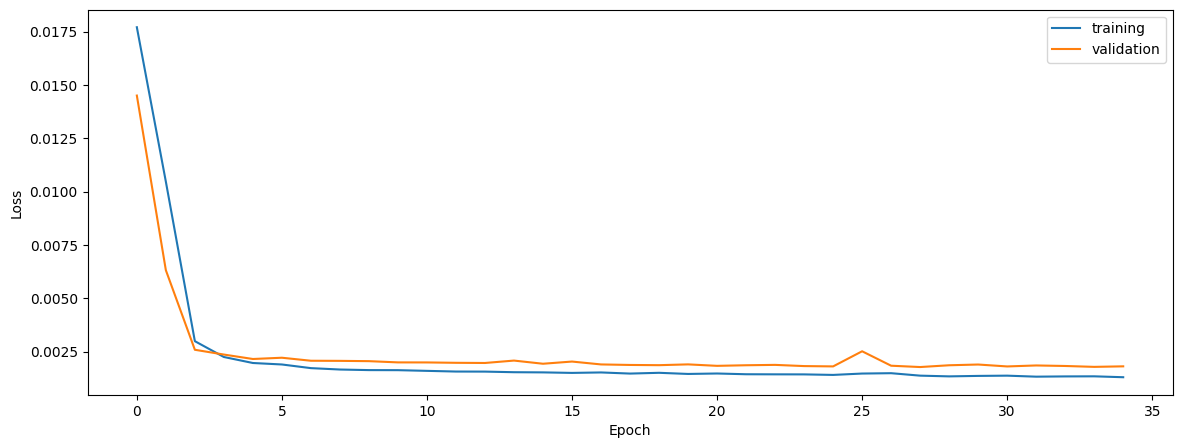

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9429774959538116
0.9370081010658553
0.9195668285160767


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.9378687936283292
0.9476287855063567
0.9388940816540884


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.9421675542707973
0.9503263200162659
0.9476857688529003


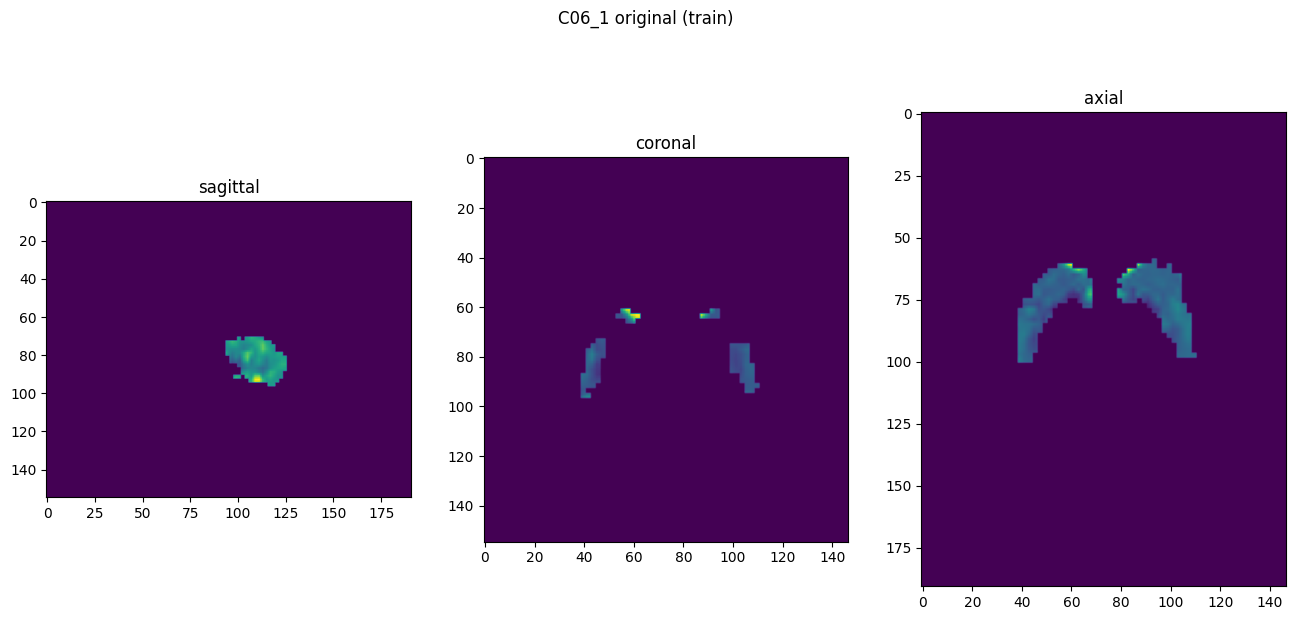

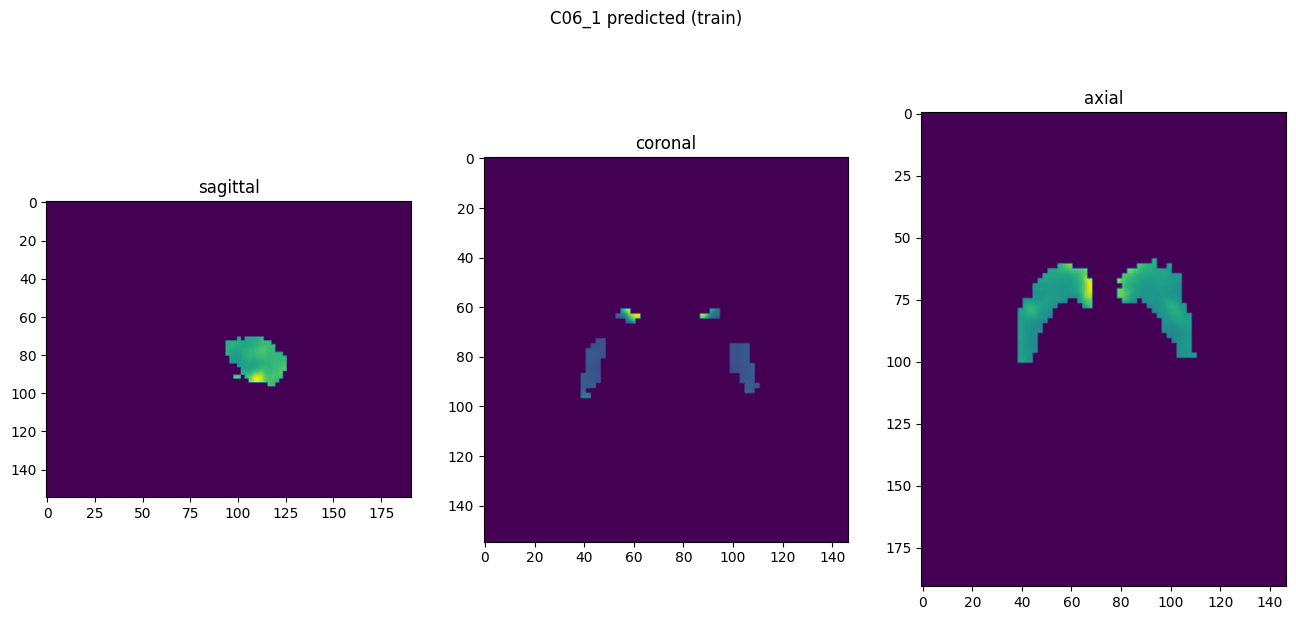

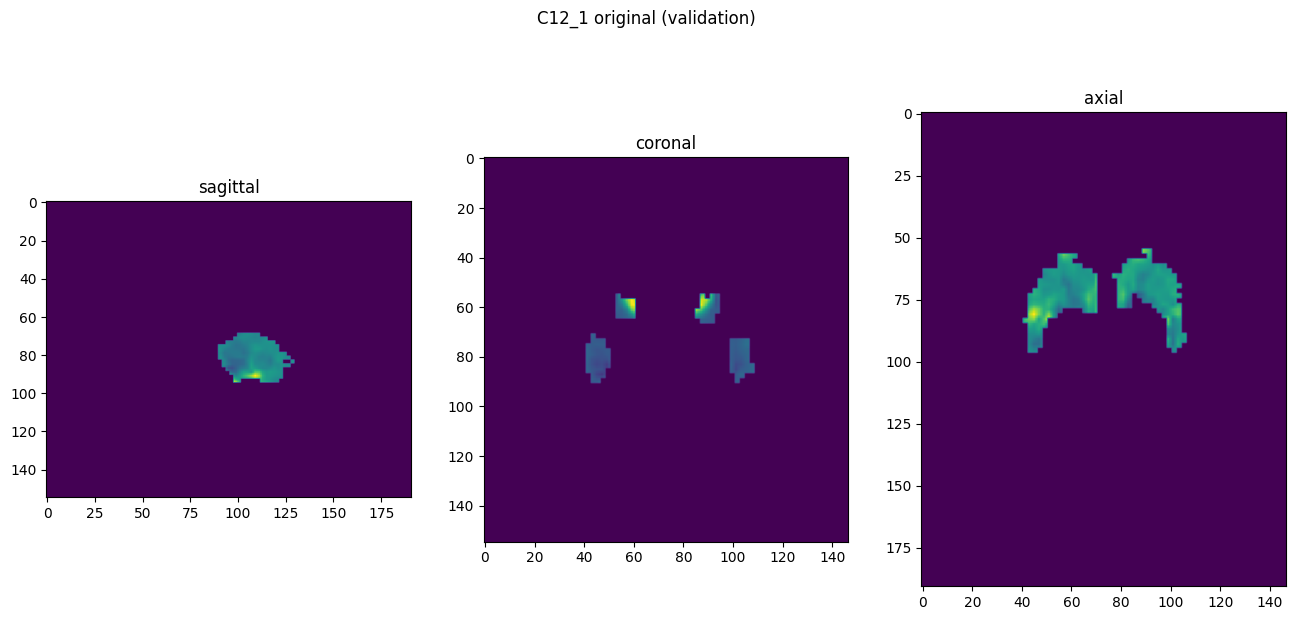

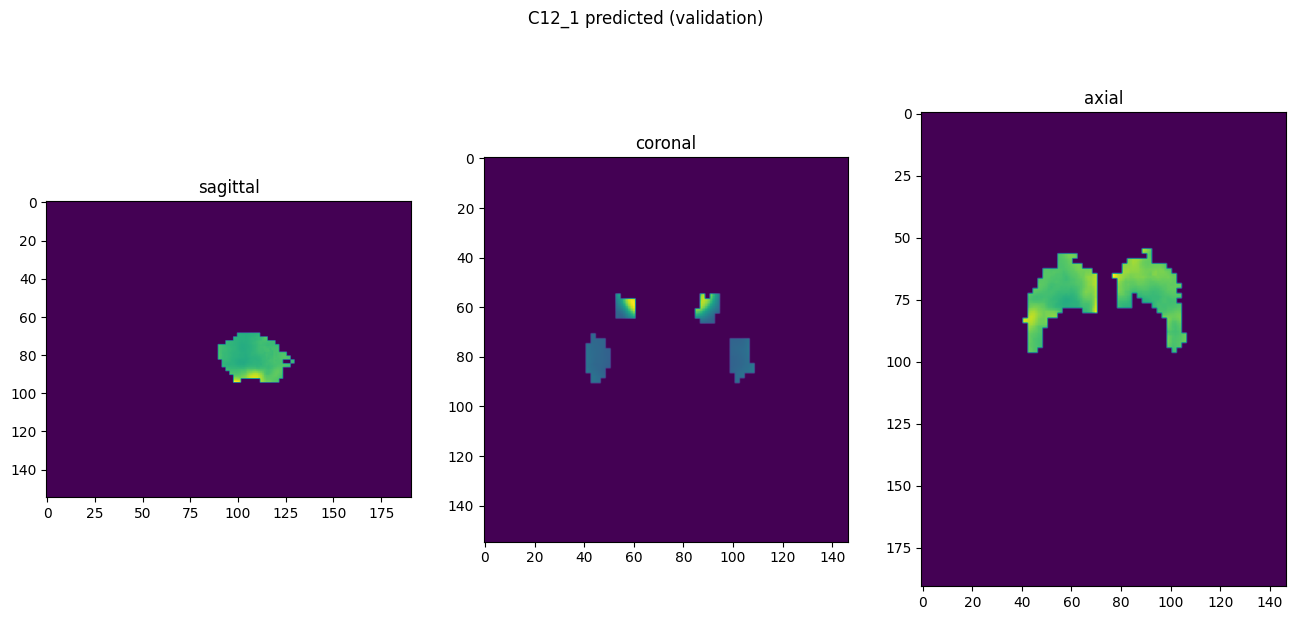

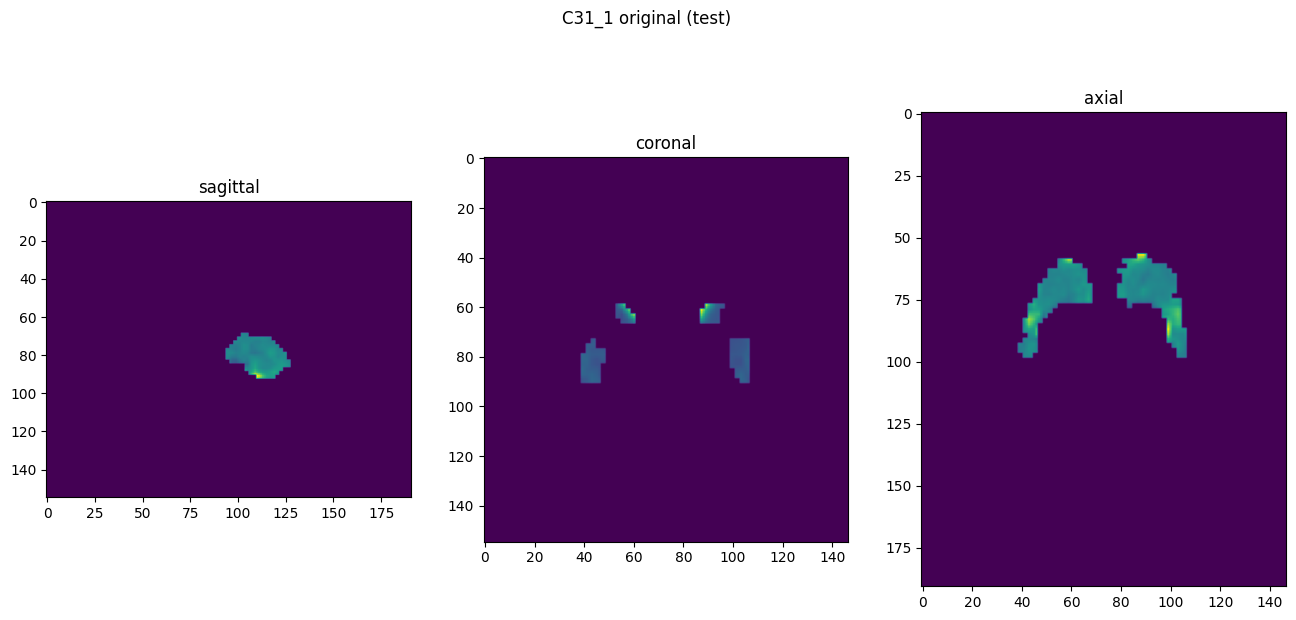

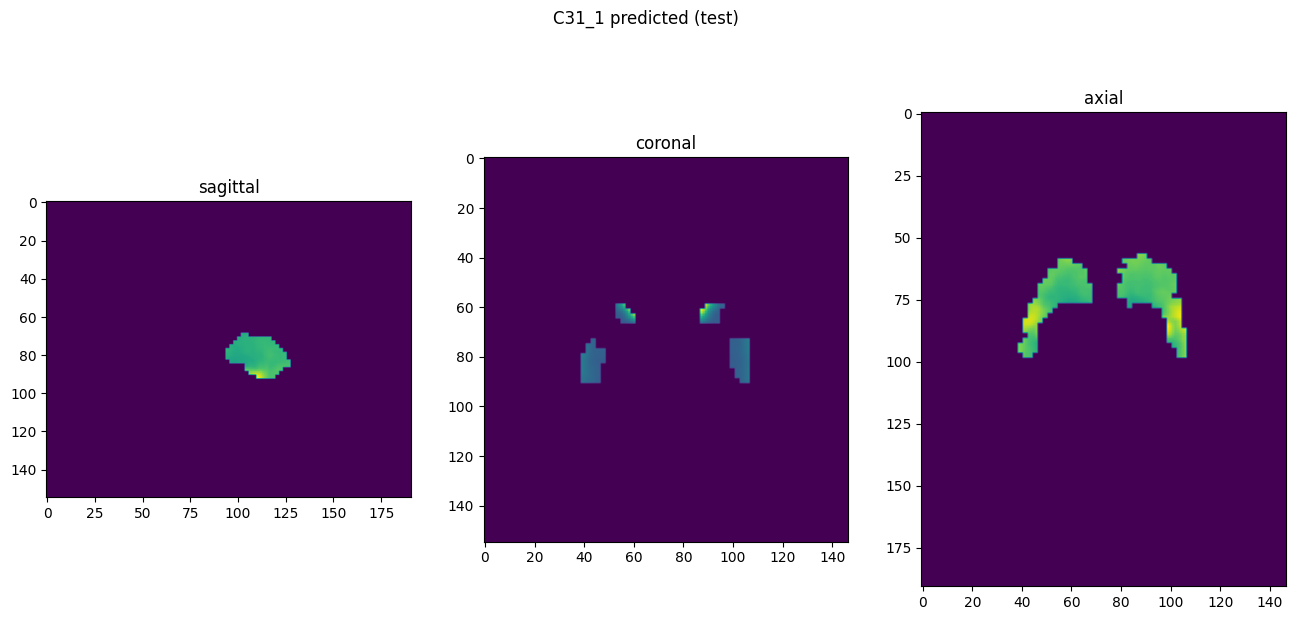

In [10]:
showResults(model, gen, threshold=None, background=False)